# Final Project Module 2

## Advance Data Retrieval and Analysis

* Student Name: Natalia Quintero 
* Student Pace: Full time
* Schedule Projec Review: TBA
* Instructor: Rafael Carrasco
* Blog Post: TBA

## Introduction

<p>The goal of this project is to test the ability to gather information from a "real-world databse" and use statistical analysis and hypothesis testing to generate analytical insights.</p>
<p>The data used for this project is sourced from Microsoft's fictional company Northwind Traders. An sqlite-compatible file has been provided and it's included in the folder along with the notebooks. The project requirements can be found in the index.ipynb file.</p>

### Sections / workflow / procedure

* Connect / analyse/ get familiar with db
* Generate questions
* For each question:
    * Define hypothesis, $Ho$ and $Ha$
    * Select significance level ($\alpha$)
    * Collect data from Northwind database (select/join tables)
    * Calculate test statistis, gather sample data and compare it with the parameter value.
    * Calculate p-value / find rejection zone. 
    * Interpretation / conclussion
* Cite sources

In [1]:
import sqlalchemy
import pandas as pd

from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

In [2]:
# Connect to the Database

engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [25]:
# Connection to execute raw SQL statements, one connection for all querys 

con = engine.connect()

-------------

## Data Munging

<p>Inspect tables, get familiar with the database.</p> 
<p>Compare table information with the ERD: looking at the diagram makes it easier to understand relations and create hypothesis, we also get a better understanding of the relationship between entities and their attributes.</p>

<img src="Northwind_ERD.png">

<img src="tableNames.png">

<p>The table names in the db are defined in singular, but this doesn't represent a major issue when retrieving data. There is an extra table that is not shown in the diagram "ProductDetails_V", this table will need to be checked later to see what information it contains in case that it becomes relevant when formulating hypothesis.</p>  
Next I proceed to save each table in a dataframe for better manipulation.

In [7]:
inspector = inspect(engine);

print(inspector.get_table_names())

2019-01-21 08:36:37,316 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-01-21 08:36:37,317 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


### Explore each table (shown in the ERD):

In [9]:
def get_columns_info(col_name):

    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for value in cols_list:
        print("Name: {} \t Type: {}".format(value['name'], value['type']))

In [14]:
get_columns_info('Category')
get_columns_info('Customer')
get_columns_info('CustomerCustomerDemo')
get_columns_info('CustomerDemographic')
get_columns_info('Employee')
get_columns_info('EmployeeTerritory')
get_columns_info('Order')
get_columns_info('OrderDetail')
get_columns_info('Product')
get_columns_info('Region')
get_columns_info('Shipper')
get_columns_info('Supplier')
get_columns_info('Territory')

Table Name: Category

Name: Id 	 Type: INTEGER
Name: CategoryName 	 Type: VARCHAR(8000)
Name: Description 	 Type: VARCHAR(8000)
Table Name: Customer

Name: Id 	 Type: VARCHAR(8000)
Name: CompanyName 	 Type: VARCHAR(8000)
Name: ContactName 	 Type: VARCHAR(8000)
Name: ContactTitle 	 Type: VARCHAR(8000)
Name: Address 	 Type: VARCHAR(8000)
Name: City 	 Type: VARCHAR(8000)
Name: Region 	 Type: VARCHAR(8000)
Name: PostalCode 	 Type: VARCHAR(8000)
Name: Country 	 Type: VARCHAR(8000)
Name: Phone 	 Type: VARCHAR(8000)
Name: Fax 	 Type: VARCHAR(8000)
Table Name: CustomerCustomerDemo

Name: Id 	 Type: VARCHAR(8000)
Name: CustomerTypeId 	 Type: VARCHAR(8000)
Table Name: CustomerDemographic

Name: Id 	 Type: VARCHAR(8000)
Name: CustomerDesc 	 Type: VARCHAR(8000)
Table Name: Employee

Name: Id 	 Type: INTEGER
Name: LastName 	 Type: VARCHAR(8000)
Name: FirstName 	 Type: VARCHAR(8000)
Name: Title 	 Type: VARCHAR(8000)
Name: TitleOfCourtesy 	 Type: VARCHAR(8000)
Name: BirthDate 	 Type: VARCHAR(8000)
Na

### Table not shown in th ERD

In [15]:
get_columns_info('ProductDetails_V')

2019-01-21 08:52:53,200 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("ProductDetails_V")
2019-01-21 08:52:53,201 INFO sqlalchemy.engine.base.Engine ()
Table Name: ProductDetails_V

Name: Id 	 Type: INTEGER
Name: ProductName 	 Type: VARCHAR(8000)
Name: SupplierId 	 Type: INTEGER
Name: CategoryId 	 Type: INTEGER
Name: QuantityPerUnit 	 Type: VARCHAR(8000)
Name: UnitPrice 	 Type: DECIMAL
Name: UnitsInStock 	 Type: INTEGER
Name: UnitsOnOrder 	 Type: INTEGER
Name: ReorderLevel 	 Type: INTEGER
Name: Discontinued 	 Type: INTEGER
Name: CategoryName 	 Type: VARCHAR(8000)
Name: CategoryDescription 	 Type: VARCHAR(8000)
Name: SupplierName 	 Type: VARCHAR(8000)
Name: SupplierRegion 	 Type: VARCHAR(8000)


In [18]:
inspector.get_pk_constraint('ProductDetails_V')

2019-01-21 09:07:09,157 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'ProductDetails_V' AND type = 'table'
2019-01-21 09:07:09,158 INFO sqlalchemy.engine.base.Engine ()


{'constrained_columns': [], 'name': None}

In [19]:
inspector.get_foreign_keys('ProductDetails_V')

2019-01-21 09:07:16,568 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("ProductDetails_V")
2019-01-21 09:07:16,569 INFO sqlalchemy.engine.base.Engine ()
2019-01-21 09:07:16,573 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'ProductDetails_V' AND type = 'table'
2019-01-21 09:07:16,574 INFO sqlalchemy.engine.base.Engine ()


[]

#### Conclussion
This table has no foreign key or primary key. It seems to be a join-table between Product and Category. Most probably was a table created and never deleted from previous manipulation of the database. I conclude this table is not part of the initial database model.

---------------

## Hypotheis Statements 

1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
2. TBD
3. TBD
4. TBD
    

### Analysis of hypothesis 1
Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

#### State null and alternative hypothesis
* $H_o$: discounts do not have an effect on the number of products ordered. $\mu_1 =\mu_2$
* $Ha$: discounts have an effect in the number of products ordered. $\mu_1 !=\mu_2$

#### Significance level 

$\alpha$ = 0.05

Since the question is asking for a "significant effect" this will be a two-tail test.

#### Collect data

Table needed: Order (attributes: orderid, quantity, discount) 

In [58]:
# Read OrderDertail table into a dataframe

dfOrderDetail = pd.read_sql_query('''select * from [OrderDetail]''', engine)

dfOrderDetail.head()

2019-01-21 16:57:46,648 INFO sqlalchemy.engine.base.Engine select * from [OrderDetail]
2019-01-21 16:57:46,650 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [55]:
dfOrderDetail['Discount'].unique()

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1 , 0.15, 0.2 , 0.25])

In [61]:
dfOrderDetail['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

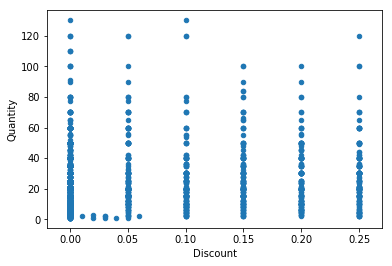

In [63]:
dfOrderDetail.plot.scatter('Discount', 'Quantity')
plt.show()

At a first look it doesn't seem that dicounts affect the quantity of products ordered.

In [37]:
# Check columns dont have null values
# Columns of interest: Quantity, Discount, productId

dfOrderDetail[['ProductId', 'Quantity', 'Discount']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 3 columns):
ProductId    2155 non-null int64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(1), int64(2)
memory usage: 50.6 KB


In [34]:
# Read Order table into a dataframe

dfOrder = pd.read_sql_query('''select * from [Order]''', engine)

dfOrder.head()

2019-01-21 14:31:33,486 INFO sqlalchemy.engine.base.Engine select * from [Order]
2019-01-21 14:31:33,489 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [38]:
# Columns of interest: CustomerId, 
dfOrder[['CustomerId']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 1 columns):
CustomerId    830 non-null object
dtypes: object(1)
memory usage: 6.6+ KB


In [45]:
# Discount and quantity 
import seaborn as sns

In [ ]:
sns.distplot()

#### Test statistic

# merge testing here!!

#### P-value / Rejection zones

#### Interpretation

### Analysis of hypothesis 2

# Sources

* [SQLAlchemy Documentation][s1] 
* [Introduction to hypothesis testing][s2]

[s1]: https://docs.sqlalchemy.org/en/latest/core/reflection.html?highlight=inspector#sqlalchemy.engine.reflection.Inspector.get_table_names.params.order_by
[s2]:https://newonlinecourses.science.psu.edu/stat500/node/39/
